In [1]:
%matplotlib inline
%pylab inline
import sympy as sym
import pylab as pl
import numpy as np
import numpy.polynomial.polynomial as n_poly
import numpy.polynomial.legendre as leg


import scipy
from scipy.interpolate import *
from scipy.integrate import *
from scipy.special import roots_legendre

from mpl_toolkits.mplot3d import Axes3D

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 2D FEM SOLVER : ALLEN-CAHN EQUATION

1D M & K Shape:  (100, 100) (100, 100)
2D M & K Shape:  (10000, 10000) (10000, 10000)
2D eta Shape:  (11, 10000)


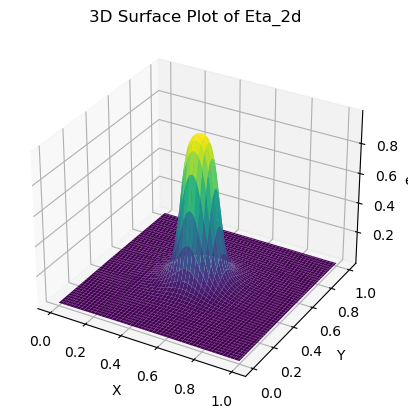

In [11]:
t = sym.var('t')
f = t**2 * (t - 1)**2
F = f.diff(t, 1)
F = sym.lambdify(t,F, 'numpy')

func2d = lambda x,y: 1/(1+100*((x-.5)**2+(y-.5)**2))
func1d = lambda x: sin(2 * pi * x)+1

ndofs = 100
degree = 2
eps = 0.01
dt = 0.1
n_steps = int(1/dt) + 1

x = linspace(0, 1, ndofs)
y = linspace(0, 1, ndofs)

basis = [PPoly.from_spline(splrep(x, np.eye(ndofs)[i], k=degree)) for i in range(ndofs)]


intervals = np.unique(basis[0].x)

qp, w = leg.leggauss(degree)
qp = (qp + 1) / 2 
w /= 2           
    
h = diff(intervals)
Q = array([intervals[i] + h[i] * qp for i in range(len(h))]).reshape((-1,))
W = array([w * h[i] for i in range(len(h))]).reshape((-1,))


m = len(basis)
dbasis = []
for i in range(m):
    dbasis.append(basis[i].derivative(1))
                  
Bq = array([basis[i](Q) for i in range(m)]).T
dBq = array([dbasis[i](Q) for i in range(m)]).T
    
M = einsum('qi, q, qj', Bq, W, Bq)
K = einsum('qi, q, qj', dBq, W, dBq)    

print("1D M & K Shape: ",M.shape, K.shape)

# Using tensor product structure for 2D from 1D assemble M
assert K.shape[0] == M.shape[0] 
m = M.shape[0]

M_2d = np.zeros((m * m, m * m))
K_2d = np.zeros((m * m, m * m))

for i in range(m):
    for j in range(m):
        for k in range(m):
            for l in range(m):
                M_2d[i * m + j, k * m + l] = M[i, k]*M[j,l]
                K_2d[i * m + j, k * m + l] = K[i, k]*M[j,l] + M[i,k]*K[j,l]
                
print("2D M & K Shape: ",M_2d.shape, K_2d.shape)

eta_2d = np.zeros((n_steps, m * m))
eta_2d[0] = func2d(x[:, np.newaxis], y[np.newaxis, :]).flatten()

b_2d = M_2d.dot(eta_2d[0] - dt * F(eta_2d[0].reshape((m, m))).flatten())

for i in range(1, n_steps):
    A_2d = M_2d + dt * eps**2 * K_2d
    eta_2d[i] = np.linalg.solve(A_2d, b_2d)
    b_2d = M_2d.dot(eta_2d[i] - dt * F(eta_2d[i].reshape((m, m))).flatten())

print("2D eta Shape: ",eta_2d.shape)    

#PLOT
eta_2d_grid = eta_2d.reshape((n_steps, m, m))

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, eta_2d_grid[-1], cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('eta')
ax.set_title('3D Surface Plot of Eta_2d')
plt.show()